# Part 1: Stitching pairs of images

In [68]:
# imports
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy



In [3]:
from pathlib import Path
from skimage.io import imread as _imread
from skimage.color import rgb2gray


def imread(filename: str, as_gray: bool = False):
    """Read image data for this part."""
    path = Path("part1") / filename
    im = _imread(path)
    if as_gray and (im.ndim == 3):
        return rgb2gray(im)
    else:
        return im


In [91]:
from skimage.feature.util import FeatureDetector, DescriptorExtractor
from skimage.transform import resize
from scipy.ndimage import rank_filter, gaussian_laplace


class fSIFT(FeatureDetector, DescriptorExtractor):
    """
    Args:
        min_sigma: 
        max_sigma:
        sigma_ratio:
        border (int): Image border distance, keypoints within the border are ignored. 
    """

    def __init__(
        self,
        min_sigma=1,
        max_sigma=50,
        n_sigma=16,
        threshold=0.1,
        harris_k=0.04,
        border=16,
        n_keypoints=500,
    ):
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma
        self.n_sigma = n_sigma

        self.threshold = threshold

        self.border = border

        self.n_keypoints = n_keypoints
        self.harris_k = harris_k

        self.keypoints = None
        self.scales = None
        self.responses = None
        self.orientations = None
        self.descriptors = None

    def _laplacian_pyramid(self, image, max_layer, downscale, sigma):
        shape0, sigma0 = image.shape, sigma
        for _ in range(max_layer):
            image_laplacian = gaussian_laplace(image, sigma0, truncate=6)
            image_laplacian = resize(image_laplacian, shape0)
            yield image_laplacian * sigma0 ** 2, sigma

            out_shape = np.ceil(np.array(im.shape) / downscale)
            image = resize(image, out_shape)
            sigma *= downscale

    def _blob_log(self, image, min_sigma=1, max_sigma=50, n_sigma=10, threshold=0.2):
        sigma_list = np.logspace(np.log10(min_sigma), np.log10(max_sigma), n_sigma)
        downscale = sigma_list[1] / sigma_list[0]
        scale_space, sigma_list = zip(
            *list(
                self._laplacian_pyramid(
                    image, max_layer=n_sigma, downscale=downscale, sigma=sigma_list[0]
                )
            )
        )

        # we are working with minimums
        scale_space = -np.stack(scale_space, axis=-1)
        sigma_list = np.array(sigma_list)

        fig, ax = plt.subplots(1, n_sigma, figsize=(15, 5))
        for i in range(n_sigma):
            ax[i].imshow(scale_space[..., i], cmap="gray")
        plt.show()

        # non-maximal suppresion along each scale
        scale_space_nms = rank_filter(
            scale_space, -1, footprint=np.ones((3,) * (scale_space.ndim - 1) + (1,))
        )
        scale_space_nms = np.max(scale_space_nms, axis=-1)
        scale_space[scale_space < scale_space_nms[..., np.newaxis]] = 0

        # DEBUG
        print(
            f"[nms], min(ss)={np.min(scale_space_nms)}, max(ss)={np.max(scale_space_nms)}"
        )
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(scale_space_nms, cmap="gray")

        # intensity filter
        y, x, s = (scale_space > threshold).nonzero()
        # build keypoint coordinate
        keypoints = np.vstack([y, x])

        # remove keypoints too close to borders
        keypoints_mask = self._mask_border_keypoints(
            scale_space_nms.shape, keypoints, self.border
        )
        # keypoints, s = keypoints[:, keypoints_mask], s[keypoints_mask]

        # DEBUG save scale list for later
        return keypoints, s, sigma_list

    def _mask_border_keypoints(self, image_shape, keypoints, distance):
        """
        Mask coordinates that are within certain distance from the border.
        
        Args:
            TBD

        Returns:
            TBD

        Reference:
            skimage.feature.util._mask_border_keypoints
        """
        rows, cols = image_shape
        mask = (
            ((distance - 1) < keypoints[0, :])
            & (keypoints[0, :] < (rows - distance + 1))
            & ((distance - 1) < keypoints[1, :])
            & (keypoints[1, :] < (cols - distance + 1))
        )
        return mask

    def _harris_pyramid(self, image, sigma_list):
        pass

    def detect(self, image):
        """
        Detect keypoints in image.
        
        Args:
            image (2D array): Input image.

        Result:
            TBD
        """

        keypoints, s, sigma_list = self._blob_log(
            image, self.min_sigma, self.max_sigma, self.n_sigma, self.threshold
        )

        # TODO return scale space pyramid
        # TODO extract descriptor based on layer

        # turn scale index to sigma, and back to radius
        r = np.array(sigma_list[s], dtype=float) * np.sqrt(2)

        self.keypoints = np.vstack([keypoints, r])
        print(self.keypoints[:, :4])

    def extract(self, image, keypoints):
        """
        Extract feature descriptors in image for given keypoints.
        
        Args:
            image (2D array): Input image.
            keypoints ((N, 2) array): Keypoint locations as (row, col).
        """


In [ ]:
from matplotlib.patches import Circle

im = imread("butterfly.jpg", as_gray=True)

detector = SIFT(min_sigma=2, max_sigma=32, n_sigma=5, threshold=0.4)
detector.detect(im)

cy, cx, r = detector.keypoints
print(f"len(blobs)={len(r)}")

fig, ax = plt.subplots(figsize=(15, 6))
ax.set_aspect("equal")
ax.imshow(im, cmap="gray")
for x, y, r in zip(cx, cy, r):
    circ = Circle((x, y), r, color="r", fill=False)
    ax.add_patch(circ)
plt.xlim(0, 100)
plt.ylim(175, 275)


In [147]:
import cv2 as cv
from skimage.feature.util import FeatureDetector, DescriptorExtractor
from skimage.util import img_as_ubyte


class SIFT(FeatureDetector, DescriptorExtractor):
    """Wrapper class for OpenCV to use scikit-image detector-extractor."""

    def __init__(
        self,
        n_features=100,
        n_octave_layers=3,
        contrast_threshold=0.04,
        edge_threshold=10,
        sigma=1.6,
    ):
        self.detector = cv.SIFT_create(
            nfeatures=n_features,
            nOctaveLayers=n_octave_layers,
            contrastThreshold=contrast_threshold,
            edgeThreshold=edge_threshold,
            sigma=sigma,
        )

        self.keypoints = None
        self.descriptors = None

    def detect(self, image):
        # cv only takes in 8U
        image = img_as_ubyte(image)
        self.keypoints_ = self.detector.detect(image)

        # extract relevant info from cv structure
        self.keypoints = np.array([keypoint.pt[::-1] for keypoint in self.keypoints_])

    def extract(self, image, keypoints=None):
        if keypoints is not None:
            raise NotImplementedError(f"'keypoints' has no effect, using cached result")

        # cv only takes in 8U
        image = img_as_ubyte(image)
        _, self.descriptors = self.detector.compute(image, self.keypoints_)


500 keypoints
500 keypoints


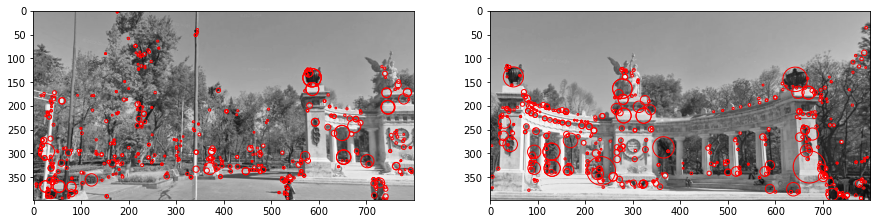

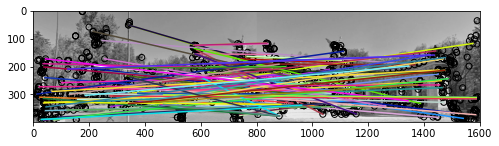

In [152]:
# test SIFT
import heapq
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist
from skimage.feature import plot_matches

images = [imread(f"{name}.jpg", as_gray=True) for name in ("left", "right")]

n_features = 500
detector = SIFT(n_features=n_features)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
keypoints = []
descriptors = []
for i, image in enumerate(images):
    detector.detect(image)
    keypoints.append(detector.keypoints)
    print(f"{len(detector.keypoints)} keypoints")

    detector.extract(image)
    descriptors.append(detector.descriptors)

    ax[i].set_aspect("equal")
    ax[i].imshow(image, cmap="gray")
    for (y, x), raw in zip(detector.keypoints, detector.keypoints_):
        circ = Circle((x, y), raw.size, color="r", fill=False)
        ax[i].add_patch(circ)

# calculate pairwise distance
distance = cdist(descriptors[0], descriptors[1], metric="sqeuclidean")
# pick top N matches for each point
n_matches = 100
n_partitions = 10
index_list = np.argpartition(distance, n_partitions)[:, :n_partitions]
index_list = np.take_along_axis(
    index_list, np.argsort(np.take_along_axis(distance, index_list, axis=-1)), axis=-1
)
# find top N matches pairs
matches_heap = []
for m0, index in enumerate(index_list):
    m1 = index[0]
    if m0 > index[0]:
        m0, m1 = m1, m0
    heapq.heappush(matches_heap, (distance[m0, m1], m0, m1))
# NOTE this does not guarantee unique points
matches = [heapq.heappop(matches_heap)[1:] for _ in range(n_matches)]
matches = np.array(matches)

matches.shape

# DEBUG temporary show matches
fig, ax = plt.subplots(figsize=(8, 6))
plot_matches(ax, images[0], images[1], keypoints[0], keypoints[1], matches)



In [ ]:
# Provided code - nothing to change here


def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect("equal")
    ax.imshow(res, cmap="gray")

    ax.plot(inliers[:, 0], inliers[:, 1], "+r")
    ax.plot(inliers[:, 2] + img1.shape[1], inliers[:, 3], "+r")
    ax.plot(
        [inliers[:, 0], inliers[:, 2] + img1.shape[1]],
        [inliers[:, 1], inliers[:, 3]],
        "r",
        linewidth=0.4,
    )
    ax.axis("off")


# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [6]:
# See assignment page for the instructions!
